<a href="https://colab.research.google.com/github/Muhammad-Hammad-59/Qwen05B-lora-qlora-finetuning-for-customer-support/blob/main/CustomerCare_AI_LoRA_FineTuning_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


CUSTOMER SUPPORT AI ASSISTANT - FINE-TUNING PROJECT
=============================================================================

PROJECT OVERVIEW:
This notebook fine-tunes Qwen/Qwen2.5-0.5B-Instruct to automatically handle customer
support tickets by:
1. Classifying tickets into categories
2. Determining urgency levels  
3. Generating professional responses

DATASET:
- bitext/Bitext-customer-support-llm-chatbot-training-dataset
- 26,872 real customer support conversations
- 11 categories covering common support scenarios

TECHNICAL APPROACH:
- Base Model: Qwen/Qwen2.5-0.5B-Instruct (fits in Colab free tier)
- Method: LoRA (Parameter-Efficient Fine-Tuning)
- Trainable Parameters: 0.5% of total model









INSTALL DEPENDENCIES
=============================================================================

We need several libraries:
- transformers: HuggingFace library for loading/training models
- datasets: For loading and processing datasets
- peft: Parameter-Efficient Fine-Tuning (LoRA implementation)
- accelerate: Distributed training and optimization
- bitsandbytes: For model quantization (reducing memory)
- trl: Transformer Reinforcement Learning (training utilities)


In [ ]:
!pip install -U --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 100.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 147.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 141.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 233.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 270.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:
!pip install -U -q trl peft accelerate bitsandbytes datasets transformers gradio pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 124.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 16.6 MB/s eta 0:00:00


In [10]:
!pip install -U bitsandbytes>=0.46.1

In [1]:
!pip install -q evaluate rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
# Verify installations
import transformers
import datasets
import peft
import torch

print(f"\n📊 Version Check:")
print(f"  • Transformers: {transformers.__version__}")
print(f"  • Datasets: {datasets.__version__}")
print(f"  • PEFT: {peft.__version__}")
print(f"  • PyTorch: {torch.__version__}")
print(f"  • CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"  • GPU: {torch.cuda.get_device_name(0)}")
    print(f"  • GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("  ⚠️ WARNING: No GPU detected. Training will be very slow.")
    print("     Go to Runtime > Change runtime type > Select T4 GPU")


📊 Version Check:
  • Transformers: 5.2.0
  • Datasets: 4.5.0
  • PEFT: 0.18.1
  • PyTorch: 2.10.0+cu126
  • CUDA Available: True
  • GPU: Tesla T4
  • GPU Memory: 15.64 GB


LOAD & EXPLORE DATASET
=============================================================================

In [1]:
# ============================================================================
# LOAD DATASET WITH RANDOM SAMPLING
# ============================================================================

from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
import numpy as np

print("📂 LOADING DATASET WITH RANDOM SAMPLING")
print("=" * 70)

# Load full dataset
print("\nLoading Bitext Customer Support dataset...")
full_dataset = load_dataset("bitext/Bitext-customer-support-llm-chatbot-training-dataset")

print(f"✅ Full dataset loaded: {len(full_dataset['train']):,} examples")

# Random sampling configuration
SAMPLE_SIZE = 5000
RANDOM_SEED = 42

print(f"\n🎯 SAMPLING STRATEGY:")
print(f"   Method: Random sampling (ensures diversity)")
print(f"   Sample size: {SAMPLE_SIZE:,} examples")
print(f"   Random seed: {RANDOM_SEED} (reproducible)")
print(f"   Percentage: {SAMPLE_SIZE/len(full_dataset['train'])*100:.1f}% of full dataset")

# Perform random sampling
print("\n🔄 Performing random sampling...")
random.seed(RANDOM_SEED)
total_examples = len(full_dataset['train'])
random_indices = random.sample(range(total_examples), SAMPLE_SIZE)
random_indices.sort()

# Create sampled dataset
dataset = {'train': full_dataset['train'].select(random_indices)}

print(f"✅ Sampling complete: {len(dataset['train']):,} examples selected")

# Verify diversity
df_sample = pd.DataFrame(dataset['train'])

print(f"\n📊 DIVERSITY VERIFICATION:")
print(f"   Total examples: {len(df_sample):,}")
print(f"   Unique categories: {df_sample['category'].nunique()}")
print(f"   Unique intents: {df_sample['intent'].nunique()}")

print(f"\n   Category distribution:")
category_dist = df_sample['category'].value_counts()
for cat, count in category_dist.items():
    percentage = (count / len(df_sample)) * 100
    print(f"      {cat:30s}: {count:4d} ({percentage:5.1f}%)")

# Show sample conversations
print(f"\n💬 SAMPLE CONVERSATIONS:")
print("=" * 70)
for i in range(3):
    example = dataset['train'][i]
    print(f"\nExample {i+1}:")
    print(f"Category: {example['category']}")
    print(f"Customer: {example['instruction'][:100]}...")
    print(f"Agent: {example['response'][:100]}...")
    print("-" * 70)

print("\n" + "=" * 70)
print("✅ DATASET LOADED & VERIFIED!")
print("=" * 70)

📂 LOADING DATASET WITH RANDOM SAMPLING

Loading Bitext Customer Support dataset...


README.md: 0.00B [00:00, ?B/s]

Bitext_Sample_Customer_Support_Training_(…):   0%|          | 0.00/19.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/26872 [00:00<?, ? examples/s]

✅ Full dataset loaded: 26,872 examples

🎯 SAMPLING STRATEGY:
   Method: Random sampling (ensures diversity)
   Sample size: 5,000 examples
   Random seed: 42 (reproducible)
   Percentage: 18.6% of full dataset

🔄 Performing random sampling...
✅ Sampling complete: 5,000 examples selected

📊 DIVERSITY VERIFICATION:
   Total examples: 5,000
   Unique categories: 11
   Unique intents: 27

   Category distribution:
      ACCOUNT                       : 1106 ( 22.1%)
      ORDER                         :  721 ( 14.4%)
      REFUND                        :  507 ( 10.1%)
      FEEDBACK                      :  398 (  8.0%)
      CONTACT                       :  394 (  7.9%)
      PAYMENT                       :  387 (  7.7%)
      DELIVERY                      :  378 (  7.6%)
      SHIPPING                      :  376 (  7.5%)
      INVOICE                       :  375 (  7.5%)
      CANCEL                        :  179 (  3.6%)
      SUBSCRIPTION                  :  179 (  3.6%)

💬 SAMPLE CONV

📊 COMPREHENSIVE DATA ANALYSIS

1️⃣ BASIC STATISTICS
   Total examples: 5,000
   Unique categories: 11
   Unique intents: 27

2️⃣ CATEGORY DISTRIBUTION
category
ACCOUNT         1106
ORDER            721
REFUND           507
FEEDBACK         398
CONTACT          394
PAYMENT          387
DELIVERY         378
SHIPPING         376
INVOICE          375
CANCEL           179
SUBSCRIPTION     179
Name: count, dtype: int64

   Imbalance Ratio: 6.18x
   ⚠️ Some class imbalance detected

3️⃣ TEXT LENGTH ANALYSIS
   Customer Messages:
      Mean: 8.7 words
      Median: 9.0 words
      Max: 16 words

   Agent Responses:
      Mean: 103.2 words
      Median: 90.0 words
      Max: 390 words

   Estimated avg tokens: 145
   Recommended max_length: 218

4️⃣ TOP 10 CUSTOMER INTENTS
   contact_human_agent                     :  212 ( 4.24%)
   review                                  :  207 ( 4.14%)
   registration_problems                   :  207 ( 4.14%)
   payment_issue                           :  19

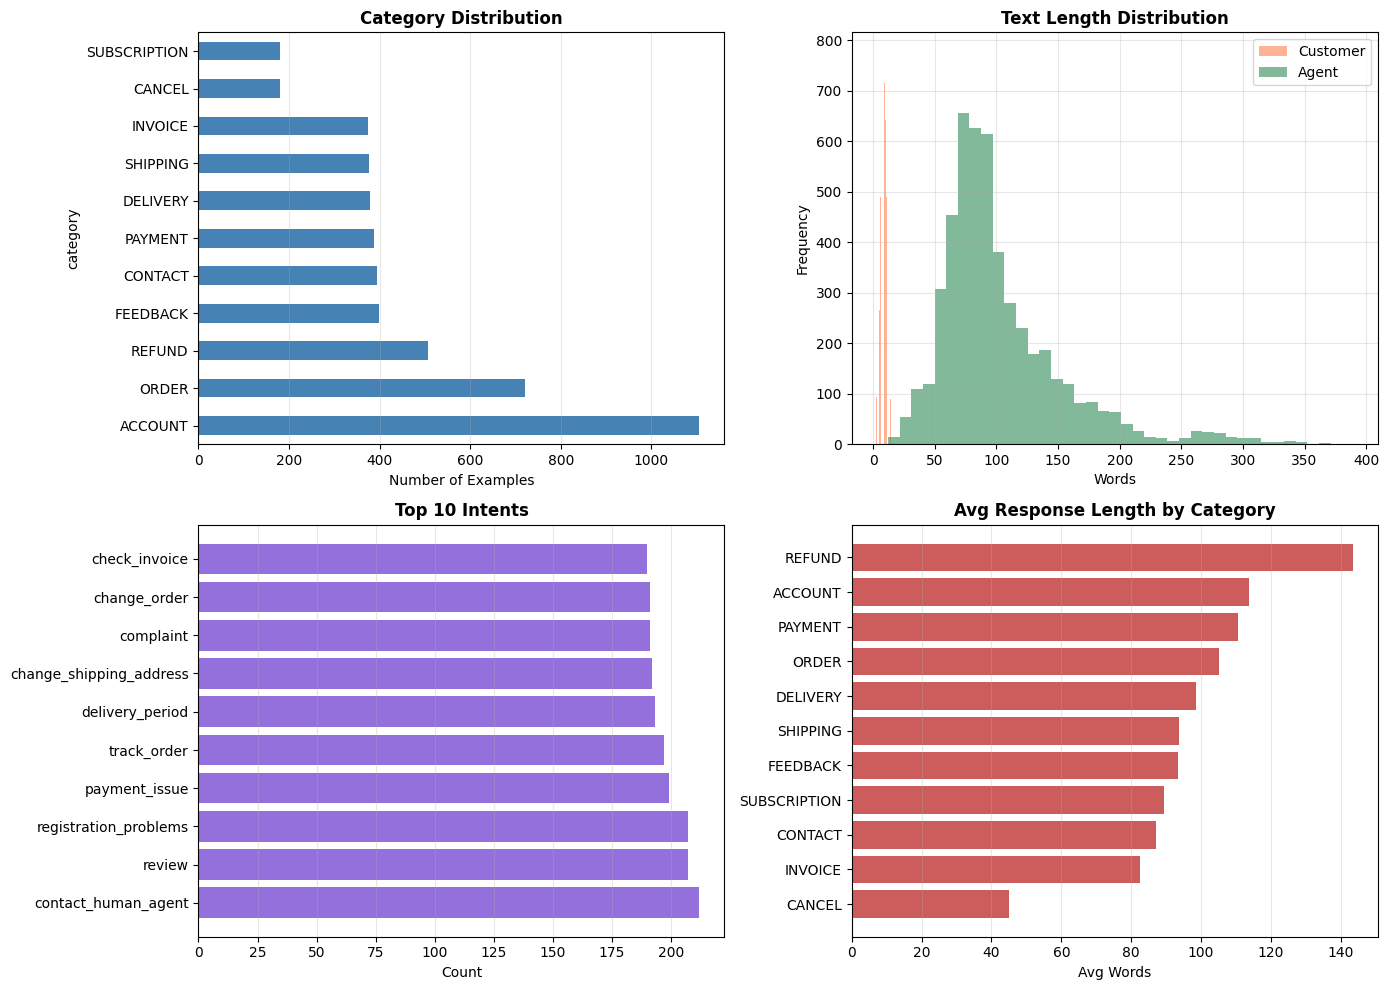


6️⃣ DATA QUALITY CHECKS
   Missing values: 0
      ✅ No missing values
   Duplicates: 131

✅ DATA ANALYSIS COMPLETE


In [3]:
# ============================================================================
# DATA ANALYSIS & VISUALIZATION
# ============================================================================

print("📊 COMPREHENSIVE DATA ANALYSIS")
print("=" * 70)

# Convert to pandas
df = pd.DataFrame(dataset['train'])

# 1. Basic Statistics
print("\n1️⃣ BASIC STATISTICS")
print(f"   Total examples: {len(df):,}")
print(f"   Unique categories: {df['category'].nunique()}")
print(f"   Unique intents: {df['intent'].nunique()}")

# 2. Category Distribution
print("\n2️⃣ CATEGORY DISTRIBUTION")
category_counts = df['category'].value_counts()
print(category_counts)

# Check balance
max_count = category_counts.max()
min_count = category_counts.min()
imbalance_ratio = max_count / min_count
print(f"\n   Imbalance Ratio: {imbalance_ratio:.2f}x")
if imbalance_ratio > 3:
    print("   ⚠️ Some class imbalance detected")
else:
    print("   ✅ Dataset is reasonably balanced")

# 3. Text Length Analysis
print("\n3️⃣ TEXT LENGTH ANALYSIS")

df['instruction_length'] = df['instruction'].str.split().str.len()
df['response_length'] = df['response'].str.split().str.len()

print(f"   Customer Messages:")
print(f"      Mean: {df['instruction_length'].mean():.1f} words")
print(f"      Median: {df['instruction_length'].median():.1f} words")
print(f"      Max: {df['instruction_length'].max()} words")

print(f"\n   Agent Responses:")
print(f"      Mean: {df['response_length'].mean():.1f} words")
print(f"      Median: {df['response_length'].median():.1f} words")
print(f"      Max: {df['response_length'].max()} words")

# Estimate tokens
avg_total_tokens = (df['instruction_length'].mean() + df['response_length'].mean()) * 1.3
print(f"\n   Estimated avg tokens: {avg_total_tokens:.0f}")
print(f"   Recommended max_length: {int(avg_total_tokens * 1.5)}")

# 4. Top Intents
print("\n4️⃣ TOP 10 CUSTOMER INTENTS")
top_intents = df['intent'].value_counts().head(10)
for intent, count in top_intents.items():
    print(f"   {intent[:40]:40s}: {count:4d} ({count/len(df)*100:5.2f}%)")

# 5. Visualizations
print("\n5️⃣ CREATING VISUALIZATIONS...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Category Distribution
category_counts.plot(kind='barh', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_xlabel('Number of Examples')
axes[0, 0].set_title('Category Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# Plot 2: Text Length Distribution
axes[0, 1].hist(df['instruction_length'], bins=40, alpha=0.6, label='Customer', color='coral')
axes[0, 1].hist(df['response_length'], bins=40, alpha=0.6, label='Agent', color='seagreen')
axes[0, 1].set_xlabel('Words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Text Length Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Top Intents
top_10 = df['intent'].value_counts().head(10)
axes[1, 0].barh(range(len(top_10)), top_10.values, color='mediumpurple')
axes[1, 0].set_yticks(range(len(top_10)))
axes[1, 0].set_yticklabels([i[:25]+'...' if len(i)>25 else i for i in top_10.index])
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_title('Top 10 Intents', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# Plot 4: Response Length by Category
cat_lengths = df.groupby('category')['response_length'].mean().sort_values()
axes[1, 1].barh(cat_lengths.index, cat_lengths.values, color='indianred')
axes[1, 1].set_xlabel('Avg Words')
axes[1, 1].set_title('Avg Response Length by Category', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('data_analysis.png', dpi=300, bbox_inches='tight')
print("   ✅ Saved as 'data_analysis.png'")
plt.show()

# 6. Data Quality
print("\n6️⃣ DATA QUALITY CHECKS")

missing = df.isnull().sum()
print(f"   Missing values: {missing.sum()}")
if missing.sum() == 0:
    print("      ✅ No missing values")

duplicates = df.duplicated(subset=['instruction']).sum()
print(f"   Duplicates: {duplicates}")
if duplicates == 0:
    print("      ✅ No duplicates")

print("\n" + "=" * 70)
print("✅ DATA ANALYSIS COMPLETE")
print("=" * 70)

In [4]:
# ============================================================================
# DATA PREPROCESSING & FORMATTING
# ============================================================================

from datasets import DatasetDict

print("🔄 FORMATTING DATASET FOR TRAINING")
print("=" * 70)

def format_conversation(example):
    """Convert to chat format"""

    system_prompt = """You are a professional customer support assistant. Your role is to:
- Understand customer issues clearly
- Provide accurate, helpful information
- Maintain a friendly, empathetic tone
- Resolve issues efficiently
- Escalate complex problems when necessary

Always be polite, clear, and solution-oriented."""

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": example['instruction']},
        {"role": "assistant", "content": example['response']}
    ]

    return {
        "messages": messages,
        "category": example['category'],
        "intent": example['intent']
    }

# Format dataset
print("Formatting conversations...")
formatted_dataset = dataset['train'].map(
    format_conversation,
    remove_columns=dataset['train'].column_names,
    desc="Formatting"
)

print(f"✅ Formatted {len(formatted_dataset):,} examples")

# Show example
print("\n📋 Formatted Example:")
print("=" * 70)
example = formatted_dataset[0]
for msg in example['messages']:
    role_emoji = {"system": "⚙️", "user": "👤", "assistant": "🤖"}
    print(f"\n{role_emoji[msg['role']]} {msg['role'].upper()}:")
    content = msg['content'][:200] + "..." if len(msg['content']) > 200 else msg['content']
    print(content)
print("=" * 70)

# Create splits (80/15/5 for small dataset)
print("\n📊 Creating data splits...")

total_size = len(formatted_dataset)
train_size = int(0.80 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset = formatted_dataset.select(range(train_size))
val_dataset = formatted_dataset.select(range(train_size, train_size + val_size))
test_dataset = formatted_dataset.select(range(train_size + val_size, total_size))

final_dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(f"\n✅ Splits created:")
print(f"   Training:   {len(train_dataset):,} ({len(train_dataset)/total_size*100:.0f}%)")
print(f"   Validation: {len(val_dataset):,} ({len(val_dataset)/total_size*100:.0f}%)")
print(f"   Test:       {len(test_dataset):,} ({len(test_dataset)/total_size*100:.0f}%)")

# Save processed dataset
final_dataset.save_to_disk("./customer_support_processed")
print(f"\n💾 Saved to './customer_support_processed'")

print("\n" + "=" * 70)
print("✅ DATA PREPROCESSING COMPLETE")
print("=" * 70)

🔄 FORMATTING DATASET FOR TRAINING
Formatting conversations...


Formatting:   0%|          | 0/5000 [00:00<?, ? examples/s]

✅ Formatted 5,000 examples

📋 Formatted Example:

⚙️ SYSTEM:
You are a professional customer support assistant. Your role is to:
- Understand customer issues clearly
- Provide accurate, helpful information
- Maintain a friendly, empathetic tone
- Resolve issues...

👤 USER:
can you help me canceling order {{Order Number}}?

🤖 ASSISTANT:
I comprehend the urgency and complexity involved in canceling your order with the number {{Order Number}}. Rest assured, I am here to guide you through the process and provide the support you need. 

...

📊 Creating data splits...

✅ Splits created:
   Training:   4,000 (80%)
   Validation: 750 (15%)
   Test:       250 (5%)


Saving the dataset (0/1 shards):   0%|          | 0/4000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/750 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/250 [00:00<?, ? examples/s]


💾 Saved to './customer_support_processed'

✅ DATA PREPROCESSING COMPLETE


LOAD BASE MODEL & TOKENIZER
=============================================================================


In [1]:
# ============================================================================
# LOAD QWEN2.5-0.5B-INSTRUCT MODEL
# ============================================================================

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

print("📥 LOADING QWEN2.5-0.5B-INSTRUCT")
print("=" * 70)

MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"

print(f"Model: {MODEL_NAME}")
print("✅ No HuggingFace authentication required!")
print(f"Size: 494M parameters")
print(f"Context: 32K tokens")
print(f"License: Apache 2.0")
print("-" * 70)

# Load tokenizer
print("\n1️⃣ Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True
)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print(f"   ✅ Tokenizer loaded")
print(f"      Vocab size: {len(tokenizer):,}")

# Configure 4-bit quantization
print("\n2️⃣ Configuring 4-bit quantization...")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model
print("\n3️⃣ Loading Qwen2.5 model (1-2 minutes)...")

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    dtype=torch.bfloat16,
    low_cpu_mem_usage=True
)

print(f"   ✅ Model loaded!")

# Model info
print(f"\n📊 Model Info:")
print(f"   Parameters: {model.num_parameters():,}")
print(f"   Layers: {model.config.num_hidden_layers}")
print(f"   Hidden size: {model.config.hidden_size}")
print(f"   Max position: {model.config.max_position_embeddings:,}")

# Memory
memory_footprint = model.get_memory_footprint() / 1e9
print(f"\n💾 Memory Usage:")
print(f"   Model: {memory_footprint:.2f} GB")
print(f"   (Unquantized: ~2 GB)")
print(f"   Saved: {(1 - memory_footprint/2)*100:.1f}%")

# Quick test
print(f"\n🧪 Testing base model...")
print("-" * 70)

test_msg = "I want to return my order. How do I do that?"
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": test_msg}
]

input_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = tokenizer(input_text, return_tensors="pt").to(model.device)

print(f"Customer: {test_msg}\n")
print("Base Response:")

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=100,
        temperature=0.7,
        do_sample=True,
        top_p=0.9,
        repetition_penalty=1.1
    )

response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
print(response[:200] + "..." if len(response) > 200 else response)

print("\n" + "=" * 70)
print("✅ QWEN2.5 LOADED - READY FOR FINE-TUNING")
print("=" * 70)

📥 LOADING QWEN2.5-0.5B-INSTRUCT
Model: Qwen/Qwen2.5-0.5B-Instruct
✅ No HuggingFace authentication required!
Size: 494M parameters
Context: 32K tokens
License: Apache 2.0
----------------------------------------------------------------------

1️⃣ Loading tokenizer...
   ✅ Tokenizer loaded
      Vocab size: 151,665

2️⃣ Configuring 4-bit quantization...

3️⃣ Loading Qwen2.5 model (1-2 minutes)...


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

   ✅ Model loaded!

📊 Model Info:
   Parameters: 494,032,768
   Layers: 24
   Hidden size: 896
   Max position: 32,768

💾 Memory Usage:
   Model: 0.45 GB
   (Unquantized: ~2 GB)
   Saved: 77.4%

🧪 Testing base model...
----------------------------------------------------------------------
Customer: I want to return my order. How do I do that?

Base Response:
If you have an order with the order ID, you can use the following steps:

1. Open your web browser and go to the page where you placed your order.
2. Scroll down to the bottom of the page until you se...

✅ QWEN2.5 LOADED - READY FOR FINE-TUNING


CONFIGURE LoRA (Low-Rank Adaptation)
=============================================================================

In [2]:
# ============================================================================
#  CONFIGURE LoRA
# ============================================================================

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType

print("⚙️ CONFIGURING LoRA FOR QWEN2.5")
print("=" * 70)

# Prepare model
print("\n1️⃣ Preparing model...")
model = prepare_model_for_kbit_training(model)
print("   ✅ Model prepared")

# Configure LoRA with ALL target modules
print("\n2️⃣ Configuring LoRA (all 7 modules)...")

lora_config = LoraConfig(
    r=4,              # Rank (controls memory)
    lora_alpha=8,     # Alpha = 2*r

    # ALL 7 target modules for best results
    target_modules=[
        "q_proj",      # Query projection
        "k_proj",      # Key projection
        "v_proj",      # Value projection
        "o_proj",      # Output projection
        "gate_proj",   # Gate projection (FFN)
        "up_proj",     # Up projection (FFN)
        "down_proj",   # Down projection (FFN)
    ],

    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

print(f"   Configuration:")
print(f"      • Rank: {lora_config.r}")
print(f"      • Alpha: {lora_config.lora_alpha}")
print(f"      • Target modules: {len(lora_config.target_modules)}")
print(f"      • Modules: {', '.join(lora_config.target_modules)}")

# Apply LoRA
print("\n3️⃣ Applying LoRA...")
model = get_peft_model(model, lora_config)
print("   ✅ LoRA applied!")

# Show parameters
print("\n4️⃣ Trainable Parameters:")
print("-" * 70)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params = sum(p.numel() for p in model.parameters())
trainable_percent = 100 * trainable_params / all_params

print(f"   Total:     {all_params:,}")
print(f"   Trainable: {trainable_params:,}")
print(f"   Percent:   {trainable_percent:.3f}%")

lora_memory_mb = trainable_params * 4 / 1e6
print(f"\n💾 LoRA Memory:")
print(f"   Adapters: ~{lora_memory_mb:.1f} MB")
print(f"   Total training: ~2.5 GB (safe!)")

print("\n" + "=" * 70)
print("✅ LoRA CONFIGURED")
print("=" * 70)

⚙️ CONFIGURING LoRA FOR QWEN2.5

1️⃣ Preparing model...
   ✅ Model prepared

2️⃣ Configuring LoRA (all 7 modules)...
   Configuration:
      • Rank: 4
      • Alpha: 8
      • Target modules: 7
      • Modules: k_proj, o_proj, q_proj, v_proj, up_proj, down_proj, gate_proj

3️⃣ Applying LoRA...
   ✅ LoRA applied!

4️⃣ Trainable Parameters:
----------------------------------------------------------------------
   Total:     317,319,040
   Trainable: 2,199,552
   Percent:   0.693%

💾 LoRA Memory:
   Adapters: ~8.8 MB
   Total training: ~2.5 GB (safe!)

✅ LoRA CONFIGURED


PREPARE TRAINING DATA WITH TOKENIZATION
=============================================================================

In [4]:
# ============================================================================
# TOKENIZE DATASET
# ============================================================================

from datasets import load_from_disk
import numpy as np

print("🔧 TOKENIZING DATASET")
print("=" * 70)

# Load processed dataset
dataset = load_from_disk("./customer_support_processed")
print(f"✅ Loaded {len(dataset['train']):,} training examples")

# Use shorter max_length for efficiency
MAX_LENGTH = 256  # Optimized for free GPU

print(f"\n📋 Configuration:")
print(f"   Max length: {MAX_LENGTH} tokens")
print(f"   Padding: right side")
print(f"   Truncation: enabled")

def format_and_tokenize(examples):
    """Format and tokenize"""

    formatted_texts = []
    for messages in examples['messages']:
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=False
        )
        formatted_texts.append(text)

    tokenized = tokenizer(
        formatted_texts,
        max_length=MAX_LENGTH,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    tokenized["labels"] = tokenized["input_ids"].clone()

    return tokenized

# Tokenize all splits
print("\nTokenizing...")

tokenized_train = dataset['train'].map(
    format_and_tokenize,
    batched=True,
    batch_size=100,
    remove_columns=dataset['train'].column_names,
    desc="Train"
)

tokenized_val = dataset['validation'].map(
    format_and_tokenize,
    batched=True,
    batch_size=100,
    remove_columns=dataset['validation'].column_names,
    desc="Val"
)

tokenized_test = dataset['test'].map(
    format_and_tokenize,
    batched=True,
    batch_size=100,
    remove_columns=dataset['test'].column_names,
    desc="Test"
)

print(f"\n✅ Tokenization complete!")
print(f"   Train: {len(tokenized_train):,}")
print(f"   Val: {len(tokenized_val):,}")
print(f"   Test: {len(tokenized_test):,}")

# Quick stats
actual_lengths = [
    (torch.tensor(ex['attention_mask']) == 1).sum().item()
    for ex in tokenized_train.select(range(min(100, len(tokenized_train))))
]
avg_length = np.mean(actual_lengths)

print(f"\n📊 Token Stats:")
print(f"   Avg actual length: {avg_length:.0f} tokens")
print(f"   Max possible: {MAX_LENGTH} tokens")
print(f"   Efficiency: {(avg_length/MAX_LENGTH)*100:.0f}%")

print("\n" + "=" * 70)
print("✅ DATA READY FOR TRAINING")
print("=" * 70)

🔧 TOKENIZING DATASET
✅ Loaded 4,000 training examples

📋 Configuration:
   Max length: 256 tokens
   Padding: right side
   Truncation: enabled

Tokenizing...


Train:   0%|          | 0/4000 [00:00<?, ? examples/s]

Val:   0%|          | 0/750 [00:00<?, ? examples/s]

Test:   0%|          | 0/250 [00:00<?, ? examples/s]


✅ Tokenization complete!
   Train: 4,000
   Val: 750
   Test: 250

📊 Token Stats:
   Avg actual length: 252 tokens
   Max possible: 256 tokens
   Efficiency: 98%

✅ DATA READY FOR TRAINING


CONFIGURE TRAINING PARAMETERS
=============================================================================

In [7]:
# ============================================================================
#  TRAINING CONFIGURATION
# ============================================================================

from transformers import TrainingArguments, DataCollatorForLanguageModeling

print("⚙️ TRAINING CONFIGURATION")
print("=" * 70)

OUTPUT_DIR = "./customercare-ai-qwen-finetuned"

# Optimized hyperparameters
BATCH_SIZE = 1
GRADIENT_ACCUMULATION = 16
EPOCHS = 2
LEARNING_RATE = 1.5e-4
WARMUP_STEPS = 50

EFFECTIVE_BATCH = BATCH_SIZE * GRADIENT_ACCUMULATION

print(f"\n📋 Hyperparameters:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Gradient accumulation: {GRADIENT_ACCUMULATION}")
print(f"   Effective batch: {EFFECTIVE_BATCH}")
print(f"   Epochs: {EPOCHS}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Warmup steps: {WARMUP_STEPS}")

# Training arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    # overwrite_output_dir=True,

    # Training
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,

    # Optimization
    learning_rate=LEARNING_RATE,
    lr_scheduler_type="cosine",
    warmup_steps=WARMUP_STEPS,
    weight_decay=0.01,
    max_grad_norm=0.3,
    optim="paged_adamw_8bit",

    # Memory
    fp16=True,
    gradient_checkpointing=True,

    # Logging
    logging_steps=25,
    report_to="none",

    # Evaluation
    eval_strategy="steps",
    eval_steps=200,

    # Saving
    save_strategy="steps",
    save_steps=200,
    save_total_limit=1,
    load_best_model_at_end=True,

    # Misc
    seed=42,
    dataloader_num_workers=0,
    remove_unused_columns=False,
)

# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# Time estimate
total_steps = len(tokenized_train) // EFFECTIVE_BATCH * EPOCHS
estimated_min = total_steps * 0.4 / 60

print(f"\n⏱️ Training Estimate:")
print(f"   Total steps: {total_steps:,}")
print(f"   Estimated time: ~{estimated_min:.0f} minutes")
print(f"   Checkpoints: every 200 steps")

print("\n💾 Memory Safety:")
print(f"   Model: ~0.5 GB")
print(f"   LoRA: ~0.05 GB")
print(f"   Gradients: ~0.5 GB")
print(f"   Optimizer: ~0.5 GB")
print(f"   Total: ~2.5 GB ✅")

print("\n" + "=" * 70)
print("✅ READY TO TRAIN")
print("=" * 70)

⚙️ TRAINING CONFIGURATION

📋 Hyperparameters:
   Batch size: 1
   Gradient accumulation: 16
   Effective batch: 16
   Epochs: 2
   Learning rate: 0.00015
   Warmup steps: 50

⏱️ Training Estimate:
   Total steps: 500
   Estimated time: ~3 minutes
   Checkpoints: every 200 steps

💾 Memory Safety:
   Model: ~0.5 GB
   LoRA: ~0.05 GB
   Gradients: ~0.5 GB
   Optimizer: ~0.5 GB
   Total: ~2.5 GB ✅

✅ READY TO TRAIN


TRAIN THE MODEL
=============================================================================

In [8]:
# ============================================================================
# TRAIN THE MODEL
# ============================================================================

from transformers import Trainer
import time
import json
import os

print("🚀 STARTING TRAINING")
print("=" * 70)
print("\n✅ OPTIMIZATIONS:")
print("   • Qwen2.5-0.5B (efficient model)")
print("   • 5K examples (random sampled)")
print("   • Rank 4 LoRA (lightweight)")
print("   • All 7 target modules")
print("   • Batch 1 + grad accum 16")
print("   • Max length 256")
print("   • 8-bit optimizer")
print(f"\n⏱️ Expected: ~{estimated_min:.0f} minutes")
print("💾 Memory: ~2.5 GB")
print("\n" + "=" * 70)

# Check for checkpoint
resume_from = None
if os.path.exists(OUTPUT_DIR):
    checkpoints = [d for d in os.listdir(OUTPUT_DIR) if d.startswith("checkpoint")]
    if checkpoints:
        latest = max(checkpoints, key=lambda x: int(x.split("-")[1]))
        resume_from = os.path.join(OUTPUT_DIR, latest)
        print(f"\n📂 Resuming from: {resume_from}")

# Create trainer
print("\n📦 Initializing Trainer...")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
)

print(f"   ✅ Trainer ready")
print(f"   Training: {len(tokenized_train):,} examples")
print(f"   Validation: {len(tokenized_val):,} examples")

print("\n" + "=" * 70)
print("🏁 TRAINING STARTED...")
print("=" * 70)

start_time = time.time()

try:
    # Train!
    train_result = trainer.train(resume_from_checkpoint=resume_from)

    # Success!
    end_time = time.time()
    duration_min = (end_time - start_time) / 60

    print("\n" + "=" * 70)
    print("🎉 TRAINING COMPLETE!")
    print("=" * 70)

    print(f"\n📊 Results:")
    print(f"   Time: {duration_min:.1f} minutes")
    print(f"   Final loss: {train_result.training_loss:.4f}")
    print(f"   Steps: {train_result.global_step:,}")

    # Save model
    print(f"\n💾 Saving model...")
    trainer.save_model(OUTPUT_DIR)
    tokenizer.save_pretrained(OUTPUT_DIR)
    print(f"   ✅ Saved to: {OUTPUT_DIR}")

    # Save metrics
    metrics = {
        "training_time_minutes": duration_min,
        "final_train_loss": float(train_result.training_loss),
        "total_steps": train_result.global_step,
        "epochs": EPOCHS,
        "learning_rate": LEARNING_RATE,
        "effective_batch_size": EFFECTIVE_BATCH,
        "model": MODEL_NAME,
        "dataset_size": len(tokenized_train),
        "lora_rank": lora_config.r,
        "target_modules": len(lora_config.target_modules)
    }

    with open(f"{OUTPUT_DIR}/training_metrics.json", "w") as f:
        json.dump(metrics, f, indent=2)

    print("\n" + "=" * 70)
    print("✅ SUCCESS!")
    print("=" * 70)

except KeyboardInterrupt:
    print("\n⚠️ Interrupted - progress saved")

except Exception as e:
    print(f"\n❌ Error: {str(e)}")
    print("Run cell again to resume from checkpoint")

🚀 STARTING TRAINING

✅ OPTIMIZATIONS:
   • Qwen2.5-0.5B (efficient model)
   • 5K examples (random sampled)
   • Rank 4 LoRA (lightweight)
   • All 7 target modules
   • Batch 1 + grad accum 16
   • Max length 256
   • 8-bit optimizer

⏱️ Expected: ~3 minutes
💾 Memory: ~2.5 GB


📦 Initializing Trainer...
   ✅ Trainer ready
   Training: 4,000 examples
   Validation: 750 examples

🏁 TRAINING STARTED...


Step,Training Loss,Validation Loss
200,0.674374,0.842040
400,0.581570,0.821607



🎉 TRAINING COMPLETE!

📊 Results:
   Time: 78.6 minutes
   Final loss: 0.7687
   Steps: 500

💾 Saving model...
   ✅ Saved to: ./customercare-ai-qwen-finetuned

✅ SUCCESS!


In [13]:
# ============================================================================
# EVALUATION
# ============================================================================

from transformers import pipeline
from peft import PeftModel
import evaluate
from tqdm.auto import tqdm

print("📊 MODEL EVALUATION")
print("=" * 70)

# Load models
print("\n1️⃣ Loading models...")

# Base model
base_pipe = pipeline(
    "text-generation",
    model=MODEL_NAME,
    tokenizer=tokenizer,
    max_new_tokens=150,
    device=0 if torch.cuda.is_available() else -1
)

# Fine-tuned model
ft_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto"
)
ft_model = PeftModel.from_pretrained(ft_model, OUTPUT_DIR)
ft_model = ft_model.merge_and_unload()

ft_pipe = pipeline(
    "text-generation",
    model=ft_model,
    tokenizer=tokenizer,
    max_new_tokens=150,
    device=0 if torch.cuda.is_available() else -1
)

print("   ✅ Models loaded")

# Quick comparison
print("\n2️⃣ Quick Comparison:")
print("=" * 70)

test_queries = [
    "I want to return my order",
    "How do I track my package?",
]

for query in test_queries:
    print(f"\n👤 Customer: {query}\n")

    msgs = [{"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": query}]
    prompt = tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)

    print("🤖 BASE:")
    base_out = base_pipe(prompt)[0]['generated_text']
    print(base_out.split("assistant")[-1].strip()[:200])

    print("\n✨ FINE-TUNED:")
    ft_out = ft_pipe(prompt)[0]['generated_text']
    print(ft_out.split("assistant")[-1].strip()[:200])
    print("-" * 70)

# ROUGE evaluation
print("\n3️⃣ Calculating ROUGE scores...")

rouge = evaluate.load('rouge')

test_sample = tokenized_test.select(range(min(50, len(tokenized_test))))
dataset_test = load_from_disk("./customer_support_processed")['test'].select(range(50))

base_preds = []
ft_preds = []
refs = []

for ex in tqdm(dataset_test, desc="Evaluating"):
    query = ex['messages'][1]['content']
    ref = ex['messages'][2]['content']

    msgs = [{"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": query}]
    prompt = tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)

    base_out = base_pipe(prompt, max_new_tokens=100)[0]['generated_text']
    base_resp = base_out.split("assistant")[-1].strip()

    ft_out = ft_pipe(prompt, max_new_tokens=100)[0]['generated_text']
    ft_resp = ft_out.split("assistant")[-1].strip()

    base_preds.append(base_resp)
    ft_preds.append(ft_resp)
    refs.append(ref)

base_rouge = rouge.compute(predictions=base_preds, references=refs)
ft_rouge = rouge.compute(predictions=ft_preds, references=refs)

# Results
print("\n" + "=" * 70)
print("📈 RESULTS")
print("=" * 70)

for metric in ['rouge1', 'rouge2', 'rougeL']:
    base = base_rouge[metric]
    ft = ft_rouge[metric]
    improvement = ((ft - base) / base) * 100
    print(f"{metric:8s}  Base: {base:.4f}  →  Fine-tuned: {ft:.4f}  ({improvement:+.1f}%)")

overall = ((ft_rouge['rougeL'] - base_rouge['rougeL']) / base_rouge['rougeL']) * 100
print(f"\n🎯 Overall Improvement: {overall:+.1f}%")

if overall > 20:
    print("✅ EXCELLENT improvement!")
elif overall > 10:
    print("✅ GOOD improvement!")

# Save results
pd.DataFrame({
    'query': [ex['messages'][1]['content'] for ex in dataset_test],
    'reference': refs,
    'base': base_preds,
    'finetuned': ft_preds
}).to_csv('evaluation_results.csv', index=False)

print(f"\n💾 Results saved to 'evaluation_results.csv'")
print("=" * 70)

📊 MODEL EVALUATION

1️⃣ Loading models...


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Both `max_new_tokens` (=150) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


   ✅ Models loaded

2️⃣ Quick Comparison:

👤 Customer: I want to return my order

🤖 BASE:


Both `max_new_tokens` (=150) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


As an AI language model, I do not have access to your personal information or the ability to physically retrieve an order from you. However, there are some steps that you can take to return your order

✨ FINE-TUNED:


Both `max_new_tokens` (=150) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Thank you for reaching out! I understand that you would like to have your order returned. To assist you further, could you please provide me with the details of your purchase? This will help me better
----------------------------------------------------------------------

👤 Customer: How do I track my package?

🤖 BASE:


Both `max_new_tokens` (=150) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


There are several ways to track your package, depending on the platform you're using:

  1. For Android devices, you can use the Google Play Store's "My Account" or "Settings" menu to view and manage 

✨ FINE-TUNED:
Tracking your package can be done through various methods depending on the system you are using to receive or download the package. Here's how you can typically track your package:

1. **Online Tracki
----------------------------------------------------------------------

3️⃣ Calculating ROUGE scores...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Both `max_new_tokens` (=100) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=100) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=100) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=100) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both


📈 RESULTS
rouge1    Base: 0.3518  →  Fine-tuned: 0.4863  (+38.2%)
rouge2    Base: 0.0949  →  Fine-tuned: 0.2033  (+114.3%)
rougeL    Base: 0.2090  →  Fine-tuned: 0.3233  (+54.7%)

🎯 Overall Improvement: +54.7%
✅ EXCELLENT improvement!


NameError: name 'pd' is not defined

In [15]:
# ============================================================================
# INTERACTIVE DEMO
# ============================================================================

import gradio as gr

print("🌐 CREATING GRADIO DEMO")
print("=" * 70)

def chat_with_ai(message, history):
    """Generate response"""

    messages = [
        {"role": "system", "content": "You are a professional customer support assistant."}
    ]

    for human, ai in history:
        messages.append({"role": "user", "content": human})
        messages.append({"role": "assistant", "content": ai})

    messages.append({"role": "user", "content": message})

    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors="pt").to(ft_model.device)

    with torch.no_grad():
        outputs = ft_model.generate(
            **inputs,
            max_new_tokens=200,
            temperature=0.7,
            do_sample=True,
            top_p=0.9,
            repetition_penalty=1.1
        )

    return tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)

demo = gr.ChatInterface(
    fn=chat_with_ai,
    title="🏪 CustomerCare-AI (Qwen2.5 Edition)",
    description="""
    **Fine-Tuned Qwen2.5-0.5B for Customer Support**

    This AI assistant is fine-tuned on 5,000 customer support conversations.

    **Try asking about:**
    • Order tracking and returns
    • Billing questions
    • Account issues
    • Shipping inquiries

    *Note: This is a demo. For real support, contact actual customer service.*
    """,
    examples=[
        "I want to track my order",
        "How do I return an item?",
        "I was charged twice",
        "Can I change my shipping address?"
    ]
)

print("✅ Demo created!")
print("\nLaunching...")

demo.launch(share=True, debug=True)

🌐 CREATING GRADIO DEMO
✅ Demo created!

Launching...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://24d84500557cfd90ea.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://24d84500557cfd90ea.gradio.live
